In [54]:
#!/usr/bin/env python
# coding: utf-8
#安裝Yahoo Finance套件
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [55]:
#確認是否安裝成功
!pip show yfinance

Name: yfinance
Version: 0.2.48
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: C:\Users\David Yang\AppData\Roaming\Python\Python312\site-packages
Requires: beautifulsoup4, frozendict, html5lib, lxml, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests
Required-by: 


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[*********************100%%**********************]  11 of 11 completed


大盤期末累積報酬率: 31.93%
做多ESG高分組期末累積報酬率: 42.01%
做空ESG低分組期末累積報酬率: -5.57%
多空套利策略期末累積報酬率: 36.44%
做多ESG低分組期末累積報酬率: 0.60%

大盤最大回撤: -18.69%
做多ESG高分組最大回撤: -22.32%
做空ESG低分組最大回撤: -24.17%
多空套利策略最大回撤: -12.21%
做多ESG低分組最大回撤: -19.68%

大盤夏普比率: 1.50
做多ESG高分組夏普比率: 1.42
做空ESG低分組夏普比率: -0.31
多空套利策略夏普比率: 1.65
做多ESG低分組夏普比率: -0.00

大盤崔娜比率: 0.32
做多ESG高分組崔娜比率: 0.49
做空ESG低分組崔娜比率: 0.11
多空套利策略崔娜比率: 2.26
做多ESG低分組崔娜比率: -0.00

大盤詹森比率: -0.00
做多ESG高分組詹森比率: 0.15
做空ESG低分組詹森比率: 0.15
多空套利策略詹森比率: 0.34
做多ESG低分組詹森比率: -0.23


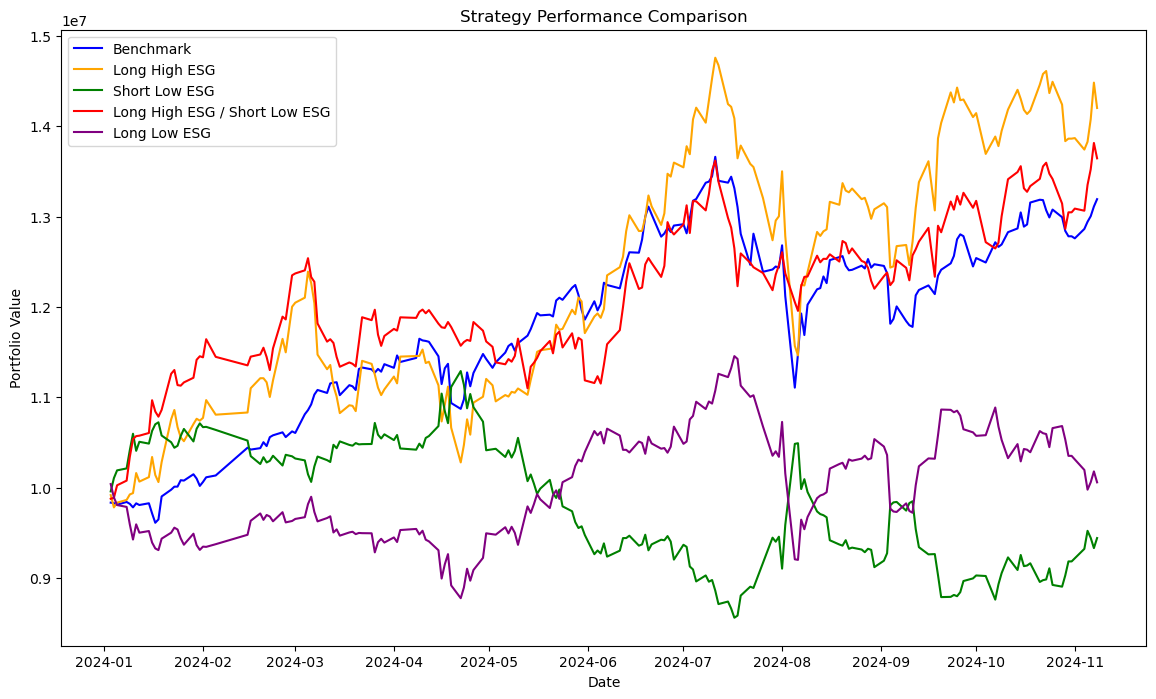

In [19]:
# 定義股票籃子和對應的比重
long_stocks = {'3227.TWO':0.2,'2345.TW': 0.2,'6806.TW':0.2,'6669.TW':0.2,'8114.TW':0.2}  # 買籃子中的股票及其比重
short_stocks = {'2351.TW':0.2,'2444.TW':0.2,'6581.TW':0.2,'6235.TW':0.2,'3022.TW':0.2}  # 放空籃子中的股票及其比重
benchmark_index = '^TWII'  # 大盤指數 (S&P 500)

# 下載資料
start_date = '2024-01-01'
end_date = '2024-11-30'
tickers = list(long_stocks.keys()) + list(short_stocks.keys()) + [benchmark_index]
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# 計算每日報酬率
returns = data.pct_change().dropna()

# 計算長倉和空倉籃子的加權回報
long_returns = sum(returns[stock] * weight for stock, weight in long_stocks.items())
short_returns = sum(returns[stock] * weight for stock, weight in short_stocks.items()) * -1  # 空倉回報為負
strategy_returns = long_returns + short_returns
benchmark_returns = returns[benchmark_index]
short_as_long_returns = sum(returns[stock] * weight for stock, weight in short_stocks.items())  # 將做空股票池作為做多

# 設置初始資金
initial_investment = 10_000_000
long_value = (1 + long_returns).cumprod() * initial_investment
short_value = (1 + short_returns).cumprod() * initial_investment
strategy_value = long_value + short_value - initial_investment  # 多空套利策略
benchmark_value = (1 + benchmark_returns).cumprod() * initial_investment
short_as_long_value = (1 + short_as_long_returns).cumprod() * initial_investment  # 做多做空股票池

# 計算最大回撤
def calculate_max_drawdown(value_series):
    peak = value_series.cummax()
    drawdown = (value_series - peak) / peak
    return drawdown.min()

max_drawdown_long = calculate_max_drawdown(long_value)
max_drawdown_short = calculate_max_drawdown(short_value)
max_drawdown_strategy = calculate_max_drawdown(strategy_value)
max_drawdown_benchmark = calculate_max_drawdown(benchmark_value)
max_drawdown_short_as_long = calculate_max_drawdown(short_as_long_value)

# 計算夏普比率、崔娜比率、詹森比率
risk_free_rate = 0.04
def calculate_sharpe_ratio(returns, risk_free_rate=0.04):
    return (returns.mean() - risk_free_rate / 252) / returns.std() * np.sqrt(252)

def calculate_treynor_ratio(returns, benchmark_returns, risk_free_rate=0.04):
    beta = np.cov(returns, benchmark_returns)[0, 1] / np.var(benchmark_returns)
    return (returns.mean() - risk_free_rate / 252) / beta * 252

def calculate_jensen_alpha(returns, benchmark_returns, risk_free_rate=0.04):
    beta = np.cov(returns, benchmark_returns)[0, 1] / np.var(benchmark_returns)
    alpha = (returns.mean() - risk_free_rate / 252) - beta * (benchmark_returns.mean() - risk_free_rate / 252)
    return alpha * 252

sharpe_ratio_long = calculate_sharpe_ratio(long_returns)
sharpe_ratio_short = calculate_sharpe_ratio(short_returns)
sharpe_ratio_strategy = calculate_sharpe_ratio(strategy_returns)
sharpe_ratio_benchmark = calculate_sharpe_ratio(benchmark_returns)
sharpe_ratio_short_as_long = calculate_sharpe_ratio(short_as_long_returns)

treynor_ratio_long = calculate_treynor_ratio(long_returns, benchmark_returns)
treynor_ratio_short = calculate_treynor_ratio(short_returns, benchmark_returns)
treynor_ratio_strategy = calculate_treynor_ratio(strategy_returns, benchmark_returns)
treynor_ratio_benchmark = calculate_treynor_ratio(benchmark_returns, benchmark_returns)
treynor_ratio_short_as_long = calculate_treynor_ratio(short_as_long_returns, benchmark_returns)

jensen_alpha_benchmark = calculate_jensen_alpha(benchmark_returns, benchmark_returns)
jensen_alpha_long = calculate_jensen_alpha(long_returns, benchmark_returns)
jensen_alpha_short = calculate_jensen_alpha(short_returns, benchmark_returns)
jensen_alpha_strategy = calculate_jensen_alpha(strategy_returns, benchmark_returns)
jensen_alpha_short_as_long = calculate_jensen_alpha(short_as_long_returns, benchmark_returns)

# 計算期末累積報酬率
final_return_long = (long_value[-1] - initial_investment) / initial_investment
final_return_short = (short_value[-1] - initial_investment) / initial_investment
final_return_strategy = (strategy_value[-1] - initial_investment) / initial_investment
final_return_benchmark = (benchmark_value[-1] - initial_investment) / initial_investment
final_return_short_as_long = (short_as_long_value[-1] - initial_investment) / initial_investment

# 輸出相關資訊
print(f"大盤期末累積報酬率: {final_return_benchmark * 100:.2f}%")
print(f"做多ESG高分組期末累積報酬率: {final_return_long * 100:.2f}%")
print(f"做空ESG低分組期末累積報酬率: {final_return_short * 100:.2f}%")
print(f"多空套利策略期末累積報酬率: {final_return_strategy * 100:.2f}%")
print(f"做多ESG低分組期末累積報酬率: {final_return_short_as_long * 100:.2f}%\n")

print(f"大盤最大回撤: {max_drawdown_benchmark * 100:.2f}%")
print(f"做多ESG高分組最大回撤: {max_drawdown_long * 100:.2f}%")
print(f"做空ESG低分組最大回撤: {max_drawdown_short * 100:.2f}%")
print(f"多空套利策略最大回撤: {max_drawdown_strategy * 100:.2f}%")
print(f"做多ESG低分組最大回撤: {max_drawdown_short_as_long * 100:.2f}%\n")

print(f"大盤夏普比率: {sharpe_ratio_benchmark:.2f}")
print(f"做多ESG高分組夏普比率: {sharpe_ratio_long:.2f}")
print(f"做空ESG低分組夏普比率: {sharpe_ratio_short:.2f}")
print(f"多空套利策略夏普比率: {sharpe_ratio_strategy:.2f}")
print(f"做多ESG低分組夏普比率: {sharpe_ratio_short_as_long:.2f}\n")

print(f"大盤崔娜比率: {treynor_ratio_benchmark:.2f}")
print(f"做多ESG高分組崔娜比率: {treynor_ratio_long:.2f}")
print(f"做空ESG低分組崔娜比率: {treynor_ratio_short:.2f}")
print(f"多空套利策略崔娜比率: {treynor_ratio_strategy:.2f}")
print(f"做多ESG低分組崔娜比率: {treynor_ratio_short_as_long:.2f}\n")

print(f"大盤詹森比率: {jensen_alpha_benchmark:.2f}")
print(f"做多ESG高分組詹森比率: {jensen_alpha_long:.2f}")
print(f"做空ESG低分組詹森比率: {jensen_alpha_short:.2f}")
print(f"多空套利策略詹森比率: {jensen_alpha_strategy:.2f}")
print(f"做多ESG低分組詹森比率: {jensen_alpha_short_as_long:.2f}")

# 繪製結果
plt.figure(figsize=(14, 8))
plt.plot(benchmark_value, label='Benchmark', color='blue')
plt.plot(long_value, label='Long High ESG', color='orange')
plt.plot(short_value, label='Short Low ESG', color='green')
plt.plot(strategy_value, label='Long High ESG / Short Low ESG', color='red')
plt.plot(short_as_long_value, label='Long Low ESG', color='purple')
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


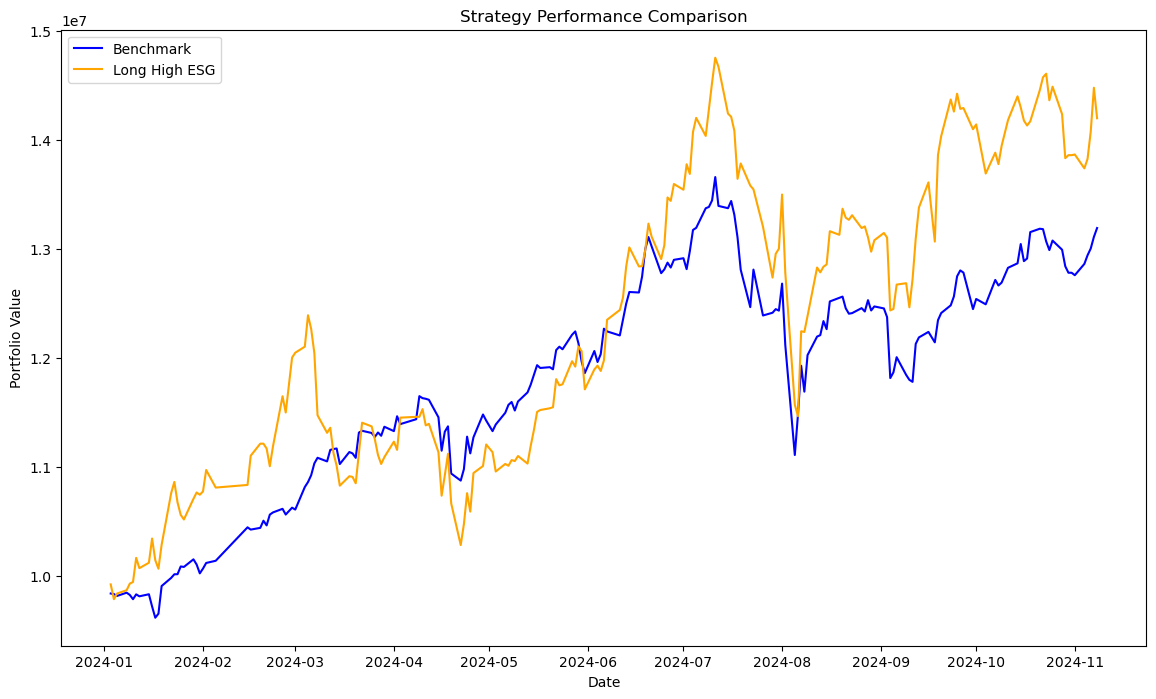

In [18]:
#benchmark vs 做多esg高分
plt.figure(figsize=(14, 8))
plt.plot(benchmark_value, label='Benchmark', color='blue')
plt.plot(long_value, label='Long High ESG', color='orange')
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

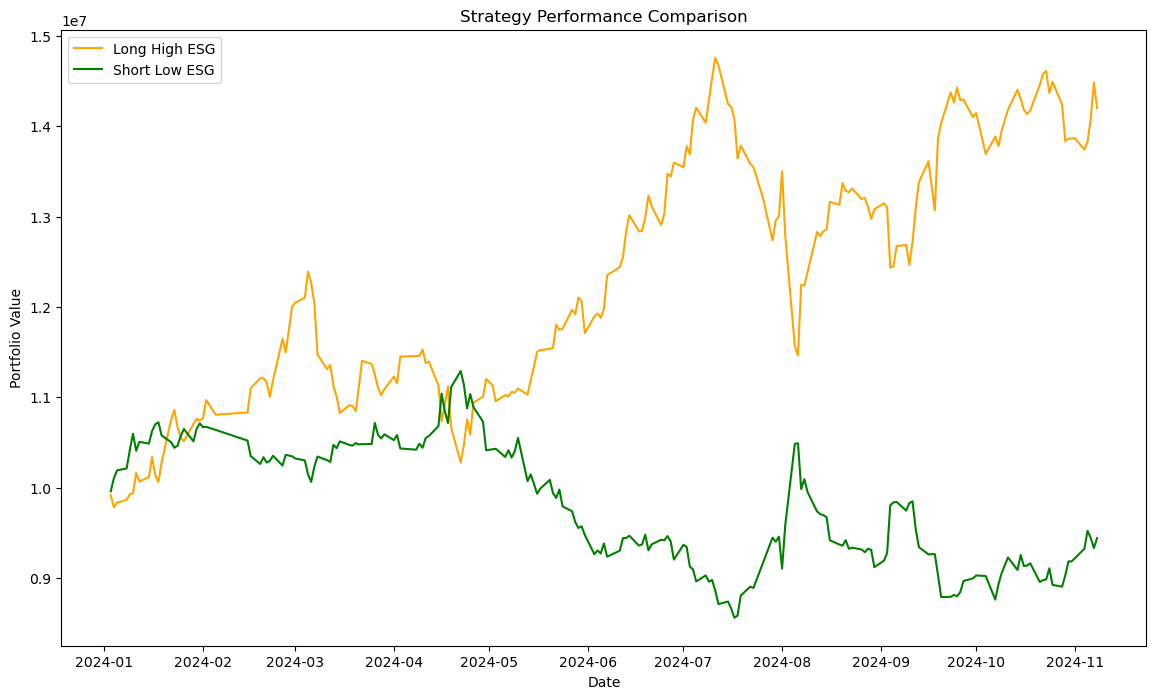

In [20]:
#做多esg高分 vs 做多esg低分
plt.figure(figsize=(14, 8))
plt.plot(long_value, label='Long High ESG', color='orange')
plt.plot(short_value, label='Short Low ESG', color='green')
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

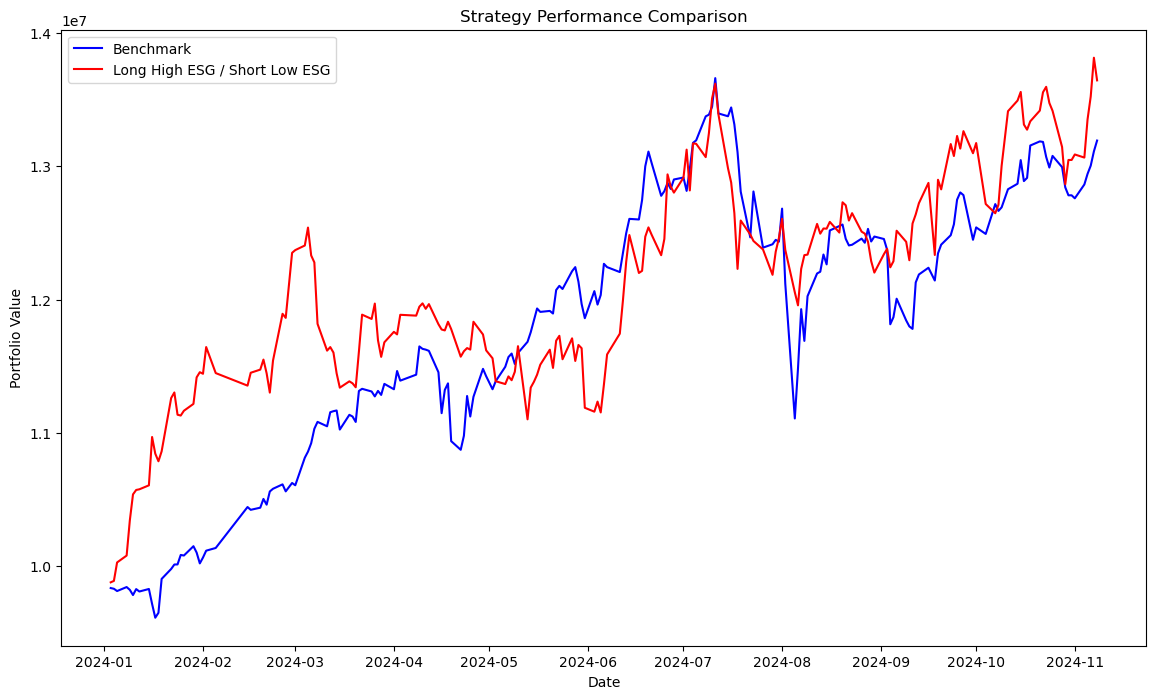

In [6]:
#benchmark vs 純多空交替 (不知道要不要放)
plt.figure(figsize=(14, 8))
plt.plot(benchmark_value, label='Benchmark', color='blue')
plt.plot(strategy_value, label='Long High ESG / Short Low ESG', color='red')
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

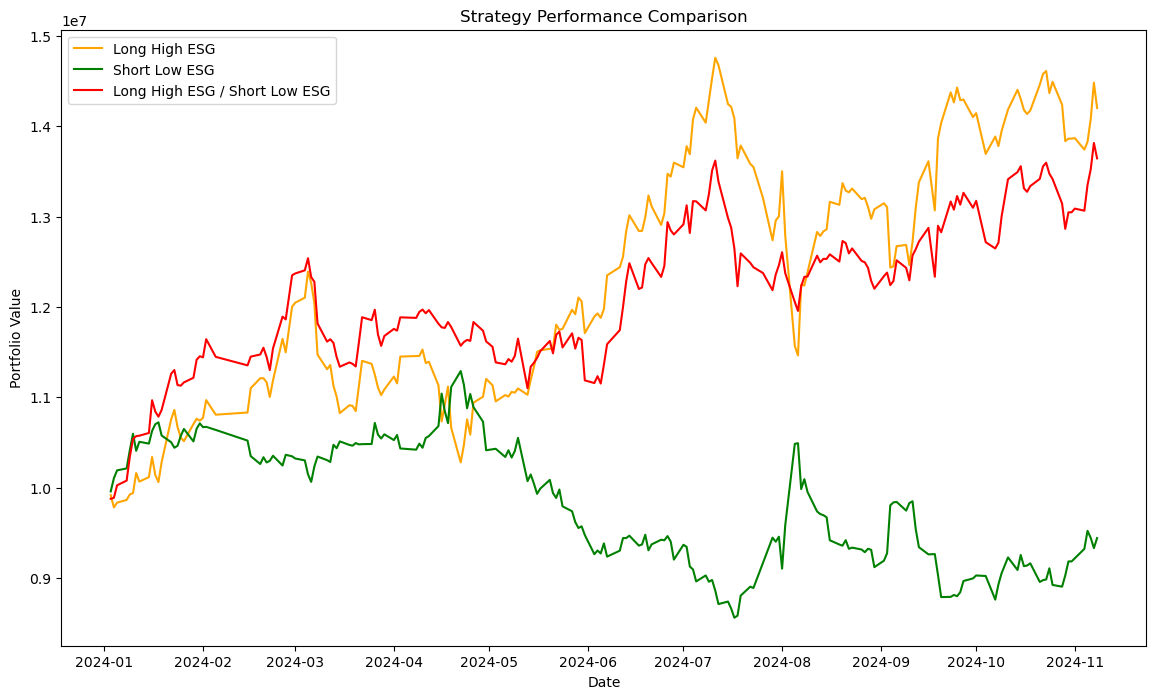

In [21]:
#純多空交替 vs 做多esg高分 vs 做空esg低分
plt.figure(figsize=(14, 8))
plt.plot(long_value, label='Long High ESG', color='orange')
plt.plot(short_value, label='Short Low ESG', color='green')
plt.plot(strategy_value, label='Long High ESG / Short Low ESG', color='red')
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

[*********************100%%**********************]  6 of 6 completed


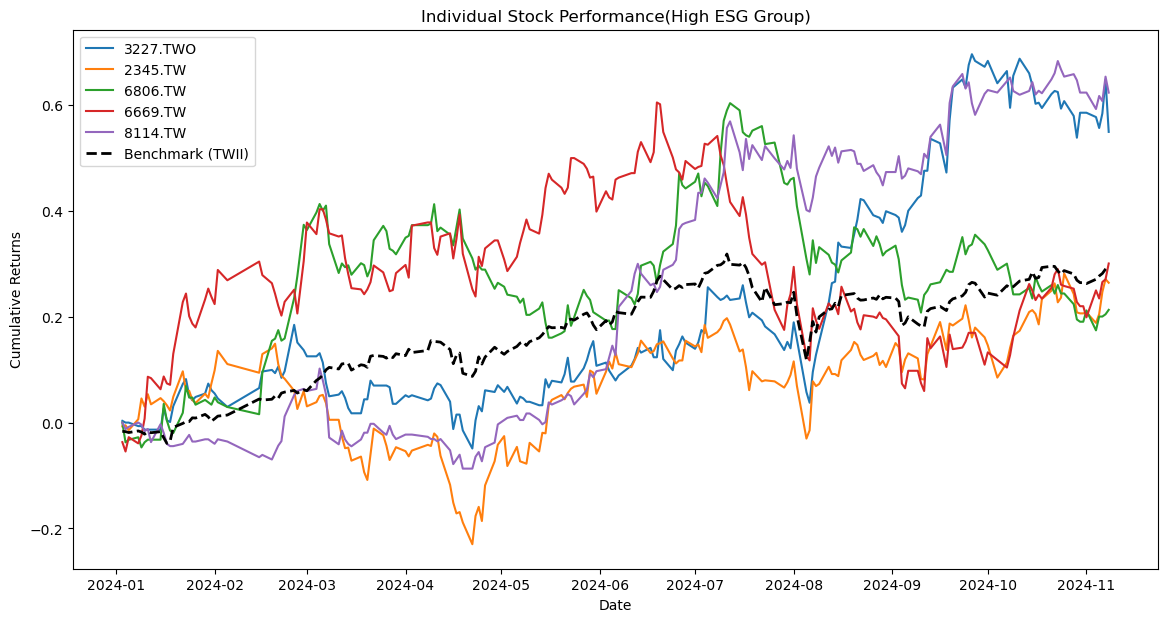

3227.TWO 期末累積報酬率: 59.04%
2345.TW 期末累積報酬率: 20.70%
6806.TW 期末累積報酬率: 12.88%
6669.TW 期末累積報酬率: 18.94%
8114.TW 期末累積報酬率: 74.90%
^TWII 期末累積報酬率: 31.93%


In [16]:
import yfinance as yf
import matplotlib.pyplot as plt

# 定義股票籃子和大盤指數
long_stocks = {'3227.TWO': 0.2, '2345.TW': 0.2, '6806.TW': 0.2, '6669.TW': 0.2, '8114.TW': 0.2}
benchmark_index = '^TWII'

# 下載數據
start_date = '2024-01-01'
end_date = '2024-11-30'
tickers = list(long_stocks.keys()) + [benchmark_index]
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# 計算每日報酬率
returns = data.pct_change().dropna()

# 繪製累積報酬率圖
plt.figure(figsize=(14, 7))
for stock in long_stocks:
    plt.plot(returns[stock].cumsum(), label=stock)  # 累積報酬率
plt.plot(returns[benchmark_index].cumsum(), label='Benchmark (TWII)', linestyle='--', linewidth=2, color='black')
plt.title('Individual Stock Performance(High ESG Group)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
# Calculate the cumulative returns for each stock and the benchmark
initial_investment = 10_000_000

# Calculate cumulative investment value for each stock
cumulative_returns = {}
for stock in long_stocks:
    cumulative_value = (1 + returns[stock]).cumprod() * initial_investment
    cumulative_returns[stock] = (cumulative_value.iloc[-1] - initial_investment) / initial_investment

# Calculate cumulative investment value for the benchmark
benchmark_value = (1 + returns[benchmark_index]).cumprod() * initial_investment
cumulative_returns[benchmark_index] = (benchmark_value.iloc[-1] - initial_investment) / initial_investment

# Print the final cumulative returns for each stock and the benchmark
for stock, return_value in cumulative_returns.items():
    print(f"{stock} 期末累積報酬率: {return_value * 100:.2f}%")



[*********************100%%**********************]  6 of 6 completed


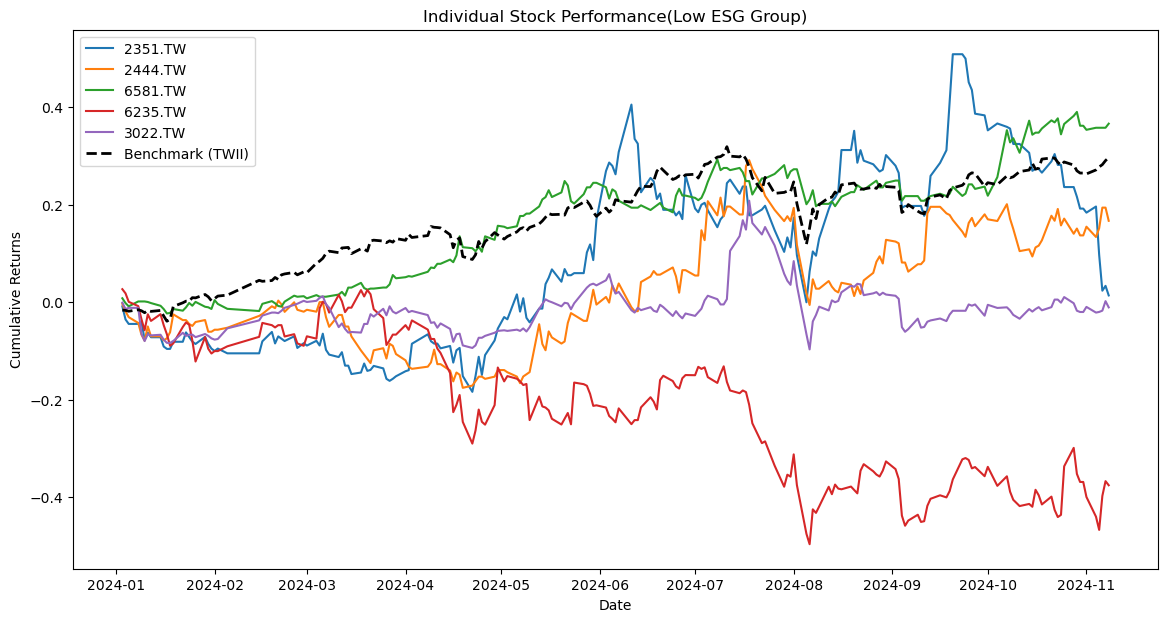

2351.TW 期末累積報酬率: -9.53%
2444.TW 期末累積報酬率: 10.34%
6581.TW 期末累積報酬率: 40.36%
6235.TW 期末累積報酬率: -36.68%
3022.TW 期末累積報酬率: -4.61%
^TWII 期末累積報酬率: 31.93%


In [17]:
import yfinance as yf
import matplotlib.pyplot as plt

short_stocks = {'2351.TW':0.2,'2444.TW':0.2,'6581.TW':0.2,'6235.TW':0.2,'3022.TW':0.2}  # 放空籃子中的股票及其比重
benchmark_index = '^TWII'  # 大盤指數 (S&P 500)

# 下載數據
start_date = '2024-01-01'
end_date = '2024-11-30'
tickers = list(short_stocks.keys()) + [benchmark_index]
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# 計算每日報酬率
returns = data.pct_change().dropna()

# 繪製累積報酬率圖
plt.figure(figsize=(14, 7))
for stock in short_stocks:
    plt.plot(returns[stock].cumsum(), label=stock)  # 累積報酬率
plt.plot(returns[benchmark_index].cumsum(), label='Benchmark (TWII)', linestyle='--', linewidth=2, color='black')
plt.title('Individual Stock Performance(Low ESG Group)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Calculate the cumulative returns for each stock and the benchmark
initial_investment = 10_000_000

# Calculate cumulative investment value for each stock
cumulative_returns = {}
for stock in short_stocks:
    cumulative_value = (1 + returns[stock]).cumprod() * initial_investment
    cumulative_returns[stock] = (cumulative_value.iloc[-1] - initial_investment) / initial_investment

# Calculate cumulative investment value for the benchmark
benchmark_value = (1 + returns[benchmark_index]).cumprod() * initial_investment
cumulative_returns[benchmark_index] = (benchmark_value.iloc[-1] - initial_investment) / initial_investment

# Print the final cumulative returns for each stock and the benchmark
for stock, return_value in cumulative_returns.items():
    print(f"{stock} 期末累積報酬率: {return_value * 100:.2f}%")

